In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import string

In [2]:
# 定义字典
char2indx = {s: i for i, s in enumerate(string.ascii_lowercase)}
char2indx

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [3]:
text = 'love'
idx = []

for i in text:
    idx.append(char2indx[i])

idx = torch.tensor(idx)
print(idx)

tensor([11, 14, 21,  4])


In [4]:
# one-hot encoder
num_claz = len(char2indx.keys())
x = F.one_hot(idx, num_classes=num_claz).float()
x, x.shape

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([4, 26]))

In [5]:
dims = 5
w = torch.randn(num_claz, dims)
(x @ w), (x @ w).shape

(tensor([[-0.5771, -1.0227, -0.9692,  2.1244, -0.3939],
         [ 0.7798, -0.7712, -0.0867,  0.4978,  0.7771],
         [-1.5788, -0.7548, -0.5611, -0.0323,  0.3460],
         [ 0.6548, -1.5422,  0.9235,  0.7958, -0.3580]]),
 torch.Size([4, 5]))

In [6]:
w[idx], w[idx].shape

(tensor([[-0.5771, -1.0227, -0.9692,  2.1244, -0.3939],
         [ 0.7798, -0.7712, -0.0867,  0.4978,  0.7771],
         [-1.5788, -0.7548, -0.5611, -0.0323,  0.3460],
         [ 0.6548, -1.5422,  0.9235,  0.7958, -0.3580]]),
 torch.Size([4, 5]))

In [7]:
class Embedding:
    def __init__(self, num_classes, embedding_dim):
        self.weights = torch.randn((num_classes, embedding_dim), requires_grad=True)

    def __call__(self, x):
        return self.weights[x]

    def parameters(self):
        return [self.weights]

In [8]:
em = Embedding(num_claz, 5)
x = torch.randint(0, num_claz, (10, ))
em(x).shape

torch.Size([10, 5])

In [9]:
x = torch.randint(0, num_claz, (20, 10))
em(x).shape, x

(torch.Size([20, 10, 5]),
 tensor([[11,  7,  0, 15,  1,  5, 17, 16, 19,  1],
         [14, 24, 23,  2,  8, 22, 24, 20, 10, 10],
         [23,  4,  6, 15,  0, 24, 17, 13, 16, 13],
         [ 6,  1, 11,  1,  7, 25, 24, 10, 14,  5],
         [24,  0, 18,  7, 22, 24, 21,  8,  4,  9],
         [20, 16, 12, 18, 17, 11, 18, 12,  0, 24],
         [22, 18, 20, 17, 21,  3, 22,  1, 17, 24],
         [15,  9, 16,  9, 23,  1, 18,  3, 14,  2],
         [ 5,  3, 16, 18,  2, 11,  9, 22, 14, 14],
         [24, 16, 19,  9,  9, 14, 18,  2, 14, 18],
         [ 4, 16, 20, 18, 22, 11, 19,  6, 11, 18],
         [25, 10,  2,  0, 24,  1, 15, 22,  3,  8],
         [ 8,  4, 16,  8, 11, 14, 16,  9,  3,  3],
         [25,  0,  9, 24, 24, 10, 10, 17,  6, 15],
         [13,  7,  1, 14, 18, 25,  8,  1,  7, 13],
         [15,  4, 24, 10,  0, 14, 17, 18,  1,  9],
         [12, 10,  4, 10, 21, 14, 22, 14, 13,  5],
         [12,  3,  0, 16,  0,  4, 22, 24,  9, 18],
         [11, 16,  1,  4, 23, 23, 23, 19, 16, 16],
     

### 自回归模型

In [10]:
torch.cuda.is_available()

True

In [11]:
# 打印GPU信息
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Laptop GPU', major=8, minor=9, total_memory=8187MB, multi_processor_count=24, uuid=8f8c63b0-9251-bdcc-0973-c237f282b5b5, L2_cache_size=32MB)


In [12]:
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt

torch.manual_seed(12046)

In [13]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 1000
learning_rate = 0.01
eval_iters = 10

In [14]:
raw_datasets = load_dataset('code_search_net', 'python', trust_remote_code=True)
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

Using the latest cached version of the module from C:\Users\shrek\.cache\huggingface\modules\datasets_modules\datasets\code_search_net\8f2524e6b62f65af5f5d65c53715c654db7b08dc93e0b7bcce2ab2f286a75be1 (last modified on Mon Jun 16 10:48:04 2025) since it couldn't be found locally at code_search_net, or remotely on the Hugging Face Hub.


In [15]:
print(datasets[8]['whole_func_string'])

def to_arrow_schema(schema):
    """ Convert a schema from Spark to Arrow
    """
    import pyarrow as pa
    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)
              for field in schema]
    return pa.schema(fields)


In [16]:
class CharTokenizer:
    def __init__(self, data, begin_ind=0, end_ind=1):
        # data : list[str]
        chars = sorted(list(set("".join(data))))
        self.char2ind = {char: i + 2 for i, char in enumerate(chars)}
        self.char2ind["<|b|>"] = begin_ind
        self.char2ind["<|e|>"] = end_ind
        self.ind2char = {i: char for char, i in self.char2ind.items()}
        self.begin_ind = begin_ind
        self.end_ind = end_ind

    def encode(self, text):
        # text : str
        return [self.char2ind[i] for i in text]

    def decode(self, inds):
        # inds : list[int] or int
        if isinstance(inds, int):
            inds = [inds]
        return [self.ind2char[i] for i in inds]

In [17]:
tokenizer = CharTokenizer(datasets['whole_func_string'])

In [18]:
# 验证
text = "def f(x):"
re = tokenizer.encode(text)
re

[71, 72, 73, 3, 73, 11, 91, 12, 29]

In [19]:
''.join(tokenizer.decode(re))

'def f(x):'

In [20]:
def autoregressive_trans(text, tokenizer, context_len=10):
    inputs, labels = [], []
    bind = tokenizer.begin_ind
    eind = tokenizer.end_ind
    enc = tokenizer.encode(text)
    data = [bind] * context_len + enc + [eind]
    for i in range(len(data) - context_len):
        inputs.append(data[i : i + context_len])
        labels.append(data[i + context_len])
    return inputs, labels

In [21]:
inputs, labels = autoregressive_trans(text, tokenizer, 3)
inputs, labels

([[0, 0, 0],
  [0, 0, 71],
  [0, 71, 72],
  [71, 72, 73],
  [72, 73, 3],
  [73, 3, 73],
  [3, 73, 11],
  [73, 11, 91],
  [11, 91, 12],
  [91, 12, 29]],
 [71, 72, 73, 3, 73, 11, 91, 12, 29, 1])

In [22]:
for a, b in zip(inputs, labels):
    print(f"{''.join(tokenizer.decode(a))} ---------> {''.join(tokenizer.decode(b))}")

<|b|><|b|><|b|> ---------> d
<|b|><|b|>d ---------> e
<|b|>de ---------> f
def --------->  
ef  ---------> f
f f ---------> (
 f( ---------> x
f(x ---------> )
(x) ---------> :
x): ---------> <|e|>


In [23]:
def process(data, tokenizer):
    text = data['whole_func_string']
    if isinstance(text, str):
        inputs, labels = autoregressive_trans(text, tokenizer)
        return {"inputs": inputs, "labels": labels}
    # data: list[str]
    inputs, labels = [], []
    for t in text:
        i, l = autoregressive_trans(t, tokenizer)
        inputs += i
        labels += l
    return {"inputs": inputs, "labels": labels}

In [24]:
tokenized_data = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
tokenized_data['train'][0]

{'repository_name': 'apache/spark',
 'func_path_in_repository': 'python/pyspark/rdd.py',
 'func_name': 'RDD.zip',
 'whole_func_string': 'def zip(self, other):\n        """\n        Zips this RDD with another one, returning key-value pairs with the\n        first element in each RDD second element in each RDD, etc. Assumes\n        that the two RDDs have the same number of partitions and the same\n        number of elements in each partition (e.g. one was made through\n        a map on the other).\n\n        >>> x = sc.parallelize(range(0,5))\n        >>> y = sc.parallelize(range(1000, 1005))\n        >>> x.zip(y).collect()\n        [(0, 1000), (1, 1001), (2, 1002), (3, 1003), (4, 1004)]\n        """\n        def get_batch_size(ser):\n            if isinstance(ser, BatchedSerializer):\n                return ser.batchSize\n            return 1  # not batched\n\n        def batch_as(rdd, batchSize):\n            return rdd._reserialize(BatchedSerializer(PickleSerializer(), batchSize))\n\

In [25]:
# 数据转换
f = lambda x: process(x, tokenizer)
tokenized = tokenized_data.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

In [26]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['inputs', 'labels'],
        num_rows: 645401
    })
    test: Dataset({
        features: ['inputs', 'labels'],
        num_rows: 67049
    })
})

In [27]:
# 查看tokenized的基本结构
print(type(tokenized))  # 可能是Dataset或DatasetDict

# 如果是DatasetDict，查看train部分的结构
if isinstance(tokenized, dict):
    print(tokenized['train'].features)  # 显示列名和类型

# 如果是单一Dataset，直接查看
else:
    print(tokenized.features)

# 查看数据示例
sample = tokenized['train'][0] if isinstance(tokenized, dict) else tokenized[0]
print({k: type(v) for k, v in sample.items()})  # 确认每列的数据类型

<class 'datasets.dataset_dict.DatasetDict'>
{'inputs': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
{'inputs': <class 'torch.Tensor'>, 'labels': <class 'torch.Tensor'>}


In [28]:
tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([645401, 10]), torch.Size([645401]))

In [29]:
train_dataloader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)

In [30]:
next(iter(train_dataloader))

{'inputs': tensor([[ 2,  3,  3,  ...,  3,  3, 85],
         [72, 87, 36,  ..., 72, 81, 87],
         [68, 81,  3,  ...,  3, 93, 76],
         ...,
         [ 3,  3,  3,  ..., 33, 33,  3],
         [80, 51, 68,  ..., 76, 82, 81],
         [ 5,  2,  3,  ..., 82, 88, 81]], device='cuda:0'),
 'labels': tensor([72, 86, 83, 88, 72,  3,  3,  3, 38, 82, 82,  3, 87, 73,  3, 81, 54,  3,
         12, 92, 39, 72, 87, 79, 83, 16,  3,  3, 29, 76,  3, 70, 88, 80, 81, 12,
          5, 72, 26, 86, 17, 85,  3,  2,  3, 70,  3, 85,  2, 72, 69, 17, 80, 68,
         76, 11, 15,  3, 76, 87,  3, 68,  2,  3, 38, 70, 81, 51, 87, 16,  3, 71,
          5, 87,  3,  3, 85, 78,  3, 72,  3, 72, 72, 87, 81, 66, 15,  3, 87, 76,
          2,  3,  2, 80, 72, 89, 75, 87, 85, 17, 72, 49, 72, 85, 87,  3, 86, 76,
         72,  3,  2, 85,  1,  3,  3,  3,  3,  3, 82,  3,  3, 72,  3, 68,  3,  3,
          3, 11, 33,  3, 81, 38, 70,  3, 72, 66, 81, 67, 92,  3, 79, 86,  3, 64,
         85,  3, 82, 16, 89, 73, 73, 82, 71, 29, 72, 

In [31]:
# 开始训练
class CharMLP(nn.Module):
    def __init__(self, vs):
        super().__init__()
        self.emb = nn.Embedding(vs, 30) # 30 个特征
        self.hidden1 = nn.Linear(10 * 30, 200) # 10 * 30 输入，200 输出
        self.hidden2 = nn.Linear(200, 100) # 200 输入，100 输出
        self.out = nn.Linear(100, vs) # 100 输入，vs 输出
    
    def forward(self, x):
        B = x.shape[0]
        emb = self.emb(x) # 输入 x 经过 embedding 得到 emb
        h = emb.view(B, -1) 
        h = F.relu(self.hidden1(h)) # (B, 200)
        h = F.relu(self.hidden2(h)) # (B, 100)
        out = self.out(h) # (B, vs)
        return out

In [32]:
model = CharMLP(len(tokenizer.char2ind)).to(device)
model

CharMLP(
  (emb): Embedding(99, 30)
  (hidden1): Linear(in_features=300, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=99, bias=True)
)

In [34]:
criterion = F.cross_entropy

# 计算损失
def estimate_loss(model):
    model.eval()
    re = {}
    with torch.no_grad():
        re['train'] = _loss(model, train_dataloader)
        re['test'] = _loss(model, test_dataloader)
    model.train()
    return re

@torch.no_grad()
def _loss(model, dataloader):
    total_loss = []
    data_iter = iter(dataloader)
    for k in range(eval_iters): # 手动控制批次数量
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(dataloader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss.append(loss.item())
    return torch.tensor(total_loss).mean().item()

estimate_loss(model)

{'train': 4.595234394073486, 'test': 4.595566272735596}

In [35]:
def train(model, optimizer, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            lossi.append(loss.item())
        stats = estimate_loss(model)
        train_loss = f"{stats['train']:.4f}"
        test_loss = f"{stats['test']:.4f}"
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    return lossi

In [36]:
@torch.no_grad()
def generate(model, context, tokenizer, max_tokens=300):
    out = []
    model.eval()
    for _ in range(max_tokens):
        outputs = model(context)
        probs = F.softmax(outputs, dim=-1) # (1, 99)
        # 随机生成下一个token
        next_token = torch.multinomial(probs, num_samples=1) # (1, 1)
        # 滑动窗口更新context
        context = torch.concat((context[:, 1:], next_token), dim=-1)
        out.append(next_token.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [42]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tokenizer.decode(generate(model, context, tokenizer))))

P|3vK9I}I8/^dAyp}LA]fwx
J6`M-n/}`O24+v4Yp?T/Cq)4/
'|maKnh}BöH<|e|>


In [43]:
l = train(model, optim.Adam(model.parameters(), lr=learning_rate))

Epoch 1/10 | Train Loss: 1.3410 | Test Loss: 1.5311
Epoch 2/10 | Train Loss: 1.2095 | Test Loss: 1.4657
Epoch 3/10 | Train Loss: 1.2008 | Test Loss: 1.3857
Epoch 4/10 | Train Loss: 1.1350 | Test Loss: 1.4074
Epoch 5/10 | Train Loss: 1.0951 | Test Loss: 1.4010
Epoch 6/10 | Train Loss: 1.0894 | Test Loss: 1.3591
Epoch 7/10 | Train Loss: 1.1102 | Test Loss: 1.3674
Epoch 8/10 | Train Loss: 1.0834 | Test Loss: 1.3670
Epoch 9/10 | Train Loss: 1.0682 | Test Loss: 1.3775
Epoch 10/10 | Train Loss: 1.0757 | Test Loss: 1.3928


In [46]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tokenizer.decode(generate(model, context, tokenizer))))

def _Pomn_ads(self))
        create the.
        Write_dtype(self, other, ', 4, 82])
        return Spark 10.0. # bits. .:
        """Returment to uring whet constat key-examplited from aval coung (bool, or None):
               from pyspark.sql ample if len, is since))
        spark._jvm.Python)

 


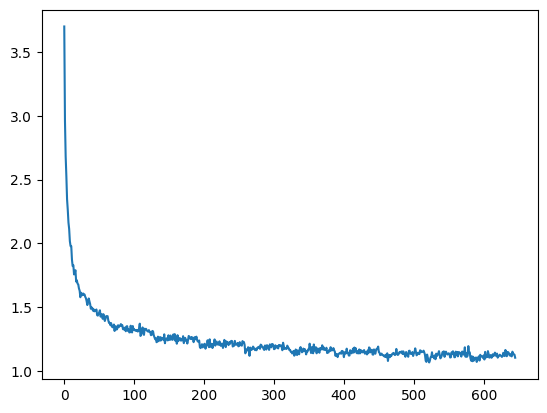

In [49]:
plt.plot(torch.tensor(l).view(-1, 10).mean(dim=-1))